Há 28 colunas de features anonimizadas para cada um dos quase 300.000 transações de cartão de crédito. A coluna `Time` registra o tempo entre transações em milissegundos. A coluna `Amount` o montante transferido. A coluna `Class` diz a label da transação: 1 para fraude e 0 para transação legítima.

In [1]:
from sklearn.preprocessing import RobustScaler
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()

df_cc = spark.read.parquet('spark-warehouse/cc_db').toPandas()

# Escalonamento
df_cc['Amount'] = RobustScaler().fit_transform(df_cc['Amount'].values.reshape(-1, 1))
df_cc['Time'] = RobustScaler().fit_transform(df_cc['Time'].values.reshape(-1, 1))

# Permutação e partição do banco de dados
# garantindo que não se testará o modelo em dados usados no treino
df_cc = df_cc.reindex(np.random.permutation(df_cc.index))

partitions = [
    int(0.8 * df_cc.shape[0]),
    int(0.9 * df_cc.shape[0])
]

df_train = df_cc.iloc[:partitions[0]].copy().reset_index(inplace = False)
df_test = df_cc.iloc[partitions[0]:partitions[1]].copy().reset_index(inplace = False)
df_validate = df_cc.iloc[:partitions[1]].copy().reset_index(inplace = False)

features = df_cc.columns.to_list()[:-1]
label = ['Class']

22/04/04 18:00:56 WARN Utils: Your hostname, freetoaster resolves to a loopback address: 127.0.1.1; using 192.168.1.98 instead (on interface wlo1)
22/04/04 18:00:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/04 18:01:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/04 18:01:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [2]:
df_train['Class'].value_counts()

0    227458
1       387
Name: Class, dtype: int64

Dada a disparidade do número de entradas legítimas em comparação com fraudulentas, faz-se necessário uma etapa de reamostragem antes de tirar conclusões sobre os dados.

In [3]:
import pandas as pd

num_frauds = df_train['Class'].sum()
df_cc_copy = df_train.copy().reindex(np.random.permutation(df_train.index))

df_cc_balanced = pd.concat([
    df_cc_copy.loc[df_cc_copy['Class'] == 1],
    df_cc_copy.loc[df_cc_copy['Class'] == 0][:num_frauds]
])

df_cc_balanced = df_cc_balanced.reindex(np.random.permutation(df_cc_balanced.index))

df_cc_balanced['Class'].value_counts()

0    387
1    387
Name: Class, dtype: int64

Observa-se que todos os V features possuem distribuição centrada em 0, desvios padrões entre [0,33; 2,00] e uma grande amplitude de valores, entre [-138; 121].

In [4]:
df_cc_balanced.describe()

,index,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,...,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000
mean,125745.341085,0.016771,-2.561984,1.846898,-3.507899,2.237199,-1.617077,-0.680837,-2.900067,0.280537,...,0.421952,-0.047004,-0.030099,-0.044005,0.026812,0.021580,0.062954,0.014931,1.103735,0.500000
std,83152.870491,0.553833,5.648174,3.773939,6.369714,3.197601,4.368692,1.831849,5.982183,5.270697,...,3.048236,1.245704,1.254599,0.558875,0.672097,0.481990,1.064060,0.442297,3.050631,0.500323
min,407.000000,-0.991530,-30.552380,-15.799625,-31.103685,-3.976414,-22.105532,-10.261990,-43.557242,-41.044261,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.149923,-7.263482,-2.810403,-0.307413,0.000000
25%,45177.000000,-0.464247,-2.983551,-0.180084,-5.036821,-0.202513,-1.776344,-1.547056,-3.109593,-0.201519,...,-0.159068,-0.566254,-0.254594,-0.395287,-0.315822,-0.304143,-0.070339,-0.063106,-0.284741,0.000000
50%,118221.500000,-0.068939,-0.918945,1.056939,-1.182387,1.364654,-0.448707,-0.634473,-0.727655,0.194344,...,0.133825,-0.036575,-0.036050,0.009112,0.045213,-0.027657,0.046350,0.031330,-0.021100,0.500000
75%,193907.750000,0.536361,0.921102,2.714025,0.367640,4.232035,0.457603,0.103561,0.255967,0.969323,...,0.713820,0.537026,0.191222,0.381559,0.389829,0.321137,0.455097,0.200582,1.089779,1.000000
max,284296.000000,1.029371,2.315631,22.057729,3.023714,11.906170,14.103918,6.474115,5.802537,20.007208,...,27.202839,8.361985,5.466230,1.093465,2.208209,2.745261,3.052358,1.779364,29.398030,1.000000


Além da grande disparidade de classe, o banco de dados mostra distribuições diferentes em função da classificação em fraude ou não.

[Text(0.5, 1.0, 'Distribuição do montante pago por classificação'),
 Text(0.5, 0, ''),
 [Text(0, 0, 'Legítima'), Text(1, 0, 'Fraudulenta')],
 Text(0, 0.5, 'Montante')]

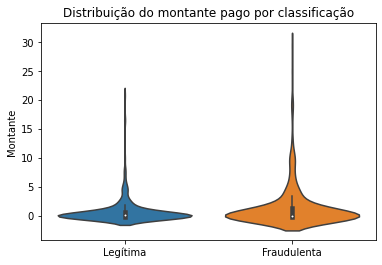

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.violinplot(
    data = df_cc_balanced,
    x = 'Class',
    y = 'Amount',
    scale = 'width'
)\
    .set(
        title = 'Distribuição do montante pago por classificação',
        xlabel = None,
        xticklabels = ['Legítima', 'Fraudulenta'],
        ylabel = 'Montante'
    )

O gráfico de violino mostra que a maior parte dos pagamentos são de pequeno valor. As transações legítimas possuem uma dispersão maior que fraudulentas.

[Text(0.5, 1.0, 'Distribuição temporal por classe'),
 Text(0.5, 0, ''),
 [Text(0, 0, 'Legítima'), Text(1, 0, 'Fraudulenta')],
 Text(0, 0.5, 'Tempo da transação')]

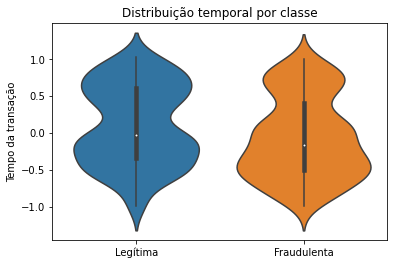

In [6]:
sns.violinplot(
    data = df_cc_balanced,
    x = 'Class',
    y = 'Time'
)\
    .set(
        title = 'Distribuição temporal por classe',
        xlabel = None,
        xticklabels = ['Legítima', 'Fraudulenta'],
        ylabel = 'Tempo da transação'
    )

Esse outro gráfico de violino mostra que ambas as classes tendem a ser bimodais.

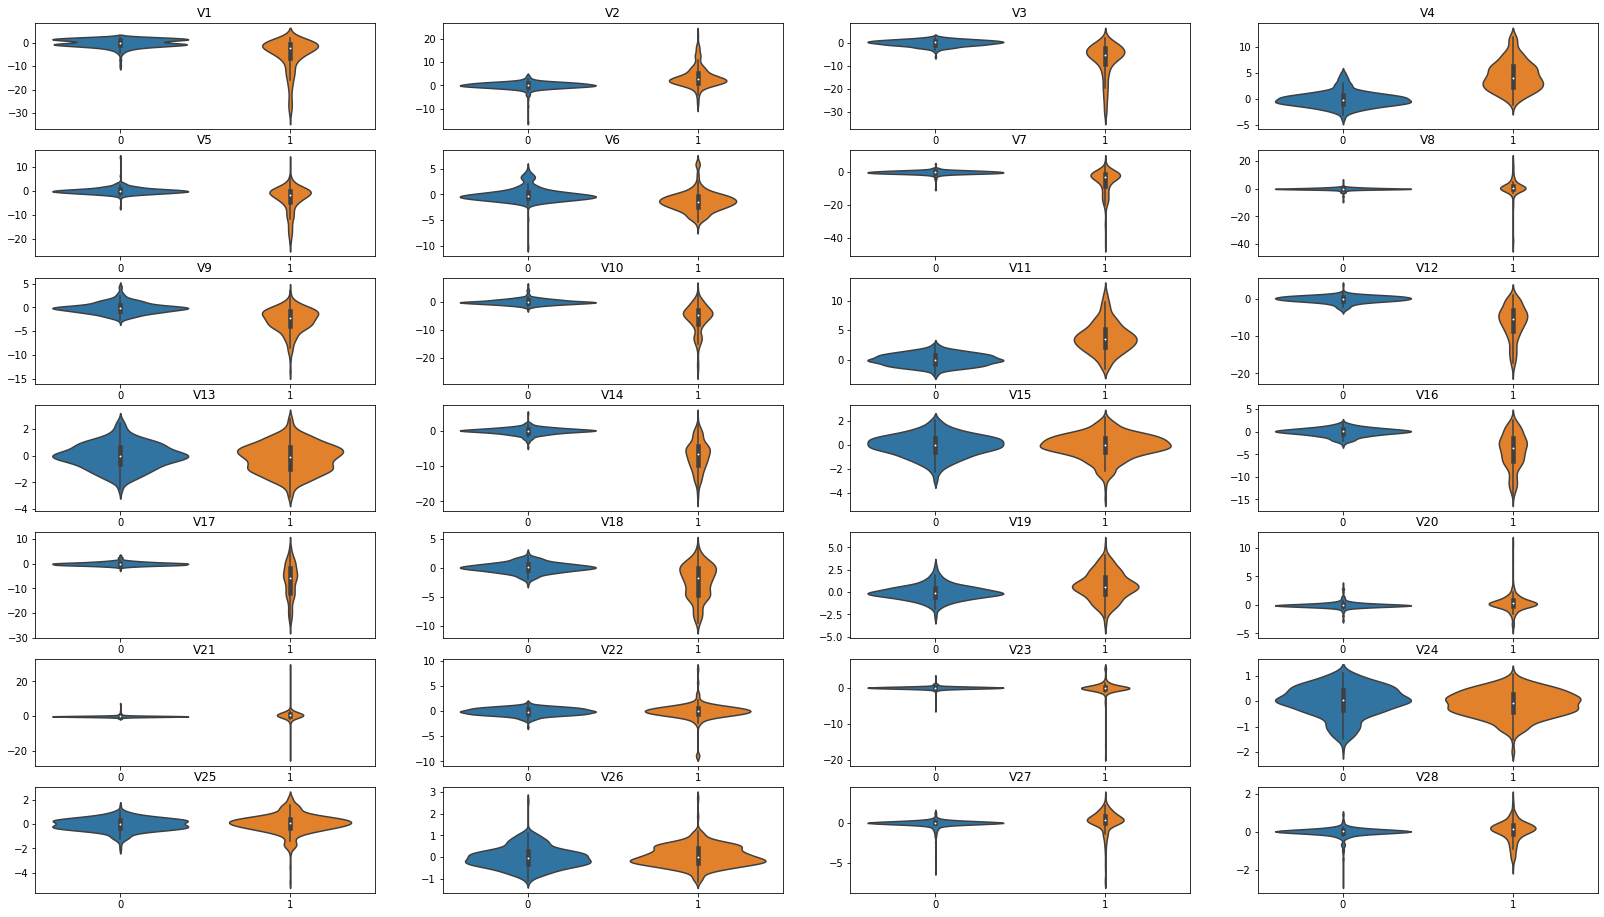

In [7]:
features.remove('Amount')
features.remove('Time')

grid_shape = (7, 4)

features = np.reshape(np.array(features), grid_shape)

fig, axs = plt.subplots(
    nrows = grid_shape[0],
    ncols = grid_shape[1],
    figsize = (4 * grid_shape[0], 4 * grid_shape[1])
)

for i in range(grid_shape[0]):
    for j in range(grid_shape[1]):
        sns.violinplot(
            data = df_cc_balanced,
            x = 'Class',
            y = features[i, j],
            ax = axs[i, j]
        )\
            .set(
                title = features[i, j],
                xlabel = None,
                ylabel = None
            )

Os gráficos de violino deixam claro que há diferenças nas distribuições de label dentre os features.
A seguir, se determina a correlação entre variáveis para testar a suposição de independência entre si.

<AxesSubplot:>

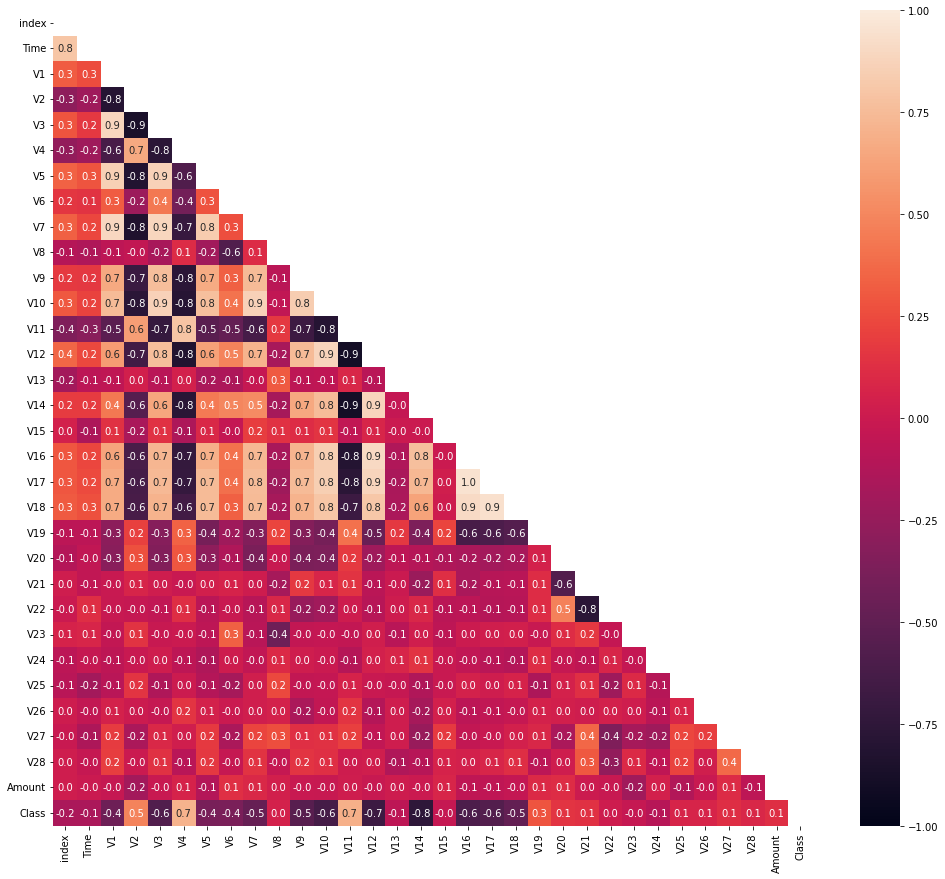

In [8]:
correlation_matrix = df_cc_balanced.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (17, 15))

sns.heatmap(
    correlation_matrix,
    mask = mask,
    annot = True,
    fmt = ".1f",
    vmin = -1.,
    vmax = 1.,
    ax = ax
)

Apenas oito (`V13`, `V15`, `V24`, `V25`, `V26`, `V27`, `V28`, `Amount`) das 30 variáveis preditivas são verdadeiramente independentes (correlação ≪ 0,5), invalidando o pressuposto para testes paramétricos.
Focando na descrição da variável de saída `Class`, observa-se com mais atenção a correlação das preditivas com essa.

Text(0.56, 17, 'Correlação de corte')

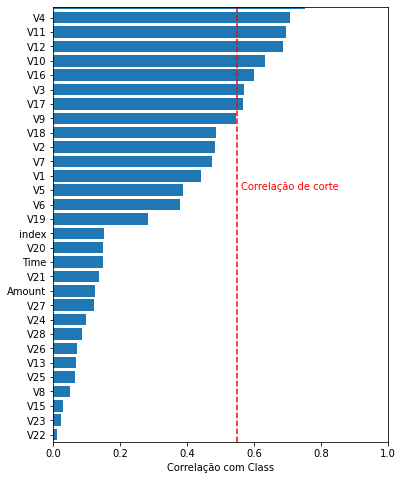

In [9]:
correlation_matrix = df_cc_balanced.corr()
corr_class = correlation_matrix.sort_values('Class', key = lambda x: abs(x))['Class'].iloc[:-1]
corr_class_labels = corr_class.index

fig, ax = plt.subplots(figsize = (6, 8))

ax.barh(
    corr_class_labels,
    abs(corr_class)
)
ax.axvline(0.55, ls = '--', color = 'red')

ax.set_xlabel('Correlação com Class')
ax.set_xlim(xmin = 0, xmax = 1)
ax.set_ylim(ymin = -0.50, ymax = 29.75)
ax.text(
    0.56,
    17,
    'Correlação de corte',
    color = 'red'
)

In [10]:
corr_choice = abs(correlation_matrix.loc['Class']) >= 0.55
training_features = correlation_matrix.loc[corr_choice]['Class'].index.to_list()
training_features

['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'Class']

Tomando correlações ≥ 0,55, escolhe-se 9 features (`V3`, `V4`, `V9`, `V10`, `V11`, `V12`, `V14`, `V16` e `V17`) dos 30 para o desenvolvimento do modelo.
Por fim, é necessário verificar se há variações significativas nas variáveis preditivas escolhidas entre as classes de fraude e legítimo.
Dado que há centenas de entradas em cada classe dessa amostra balanceada, pode-se aplicar um teste estatístico parametrizado graças ao teorema do valor central.
Para isso se usará o teste $t$ hipótese nula supondo que a distribuição das classes é idêntica.
A rejeição da hipótese nula se dará com $p \leq 0,05$.

In [11]:
from scipy.stats import ttest_ind

fraud = df_cc_balanced.loc[df_cc_balanced['Class'] == 1][training_features].reset_index(drop=True)
legit = df_cc_balanced.loc[df_cc_balanced['Class'] == 0][training_features].reset_index(drop=True)
alpha = 0.05

for feat in training_features[:-1]:
    p = ttest_ind(fraud[feat].to_numpy(), legit[feat].to_numpy()).pvalue
    if p < alpha:
        print(f'A divisão em classes deve provocar diferenças significativas em {feat}.')
    else:
        print(f'A divisão em classes não deve provocar diferenças significativas em {feat}.')


A divisão em classes deve provocar diferenças significativas em V3.
A divisão em classes deve provocar diferenças significativas em V4.
A divisão em classes deve provocar diferenças significativas em V10.
A divisão em classes deve provocar diferenças significativas em V11.
A divisão em classes deve provocar diferenças significativas em V12.
A divisão em classes deve provocar diferenças significativas em V14.
A divisão em classes deve provocar diferenças significativas em V16.
A divisão em classes deve provocar diferenças significativas em V17.


Em suma, modelar uma distribuição logística generalizada para esses dados deve ser capaz de descrever a classe dos clientes.
Tanto o teste quanto a validação serão feitos com partições da distribuição desbalanceada, imitando o cenário real.

In [12]:
dbs = [
    [spark.createDataFrame(df_cc_balanced[training_features]), 'db_cc_train'],
    [spark.createDataFrame(df_test[training_features]), 'db_cc_test'],
    [spark.createDataFrame(df_validate[training_features]), 'db_cc_validate']
]

for db in dbs:
    db[0].write.format('parquet').saveAsTable(db[1])

22/04/04 18:02:08 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/04/04 18:02:09 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
22/04/04 18:02:09 WARN TaskSetManager: Stage 4 contains a task of very large size (2392 KiB). The maximum recommended task size is 1000 KiB.
